# In Class Kaggle Classification Problem : Marketing Campaign Evaluation

**The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.**

**Dataset can be downloaded at [Github Link](https://github.com/anujk3/ml_datasets/tree/master/aml-kaggle)**


**Data Description** 

*Bank client data*

1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) <br>
4 - education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') <br>
5 - default: has credit in default? (categorical: 'no','yes','unknown') <br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown') <br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown') <br>

*Related with the last contact of the current campaign*

8 - contact: contact communication type (categorical: 'cellular','telephone') <br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') <br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') <br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

*Other attributes*

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) <br>
14 - previous: number of contacts performed before this campaign and for this client (numeric) <br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

*Social and Economic context attributes*

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) <br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) <br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric) <br>
20 - nr.employed: number of employees - quarterly indicator (numeric)

## Import Libraries, Load Data

In [1]:
#write code below, you can make multiple cells
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import SGDClassifier, LassoCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour
# from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading the data

In [2]:
plt.rcParams["figure.dpi"] = 100

data_df = pd.read_csv("./data/data.csv")
data_df.drop("duration", axis=1, inplace=True)

holdout_df = pd.read_csv("./data/holdout.csv")
holdout_df.drop("duration", axis=1, inplace=True)

subscribed = data_df.subscribed
data_df = data_df.drop("subscribed", axis=1)

subscribed = subscribed == "yes"
data_df.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0


In [3]:
data_df.shape

(32950, 19)

# Step1 - Exploration and Preparation

# Exploration:

### Descriptive Statistics for Continuous Variables

In [4]:
#write code below, you can make multiple cells
# Summary statistics of quantitative variables and categorical variables
data_df.describe()

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,2.641639,961.537906,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.803230,189.209917,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,2.000000,999.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,3.000000,999.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,56.000000,999.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


We make the following observations from the descriptive statistics above:
* The variables 'prev_days' has many '999' (missing) values.
* 'prev_contacts' = 0 for most of the data
* Rest of the continuous variables seem clean and well populated.

### Descriptive Statistics for Categorical Variables

In [5]:
data_df.describe(include=["object"])

,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,prev_outcomes
count,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,8342,19955,9760,26059,17176,27179,20902,11016,6945,28423


* We have 10 categorical variables


In [6]:
categorical_vars = data_df.describe(include=["object"]).columns
continuous_vars = data_df.describe().columns

In [7]:
continuous_vars

Index(['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')

In [8]:
categorical_vars

Index(['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'prev_outcomes'],
      dtype='object')

### Visualizing Distribution of Continuous Variables

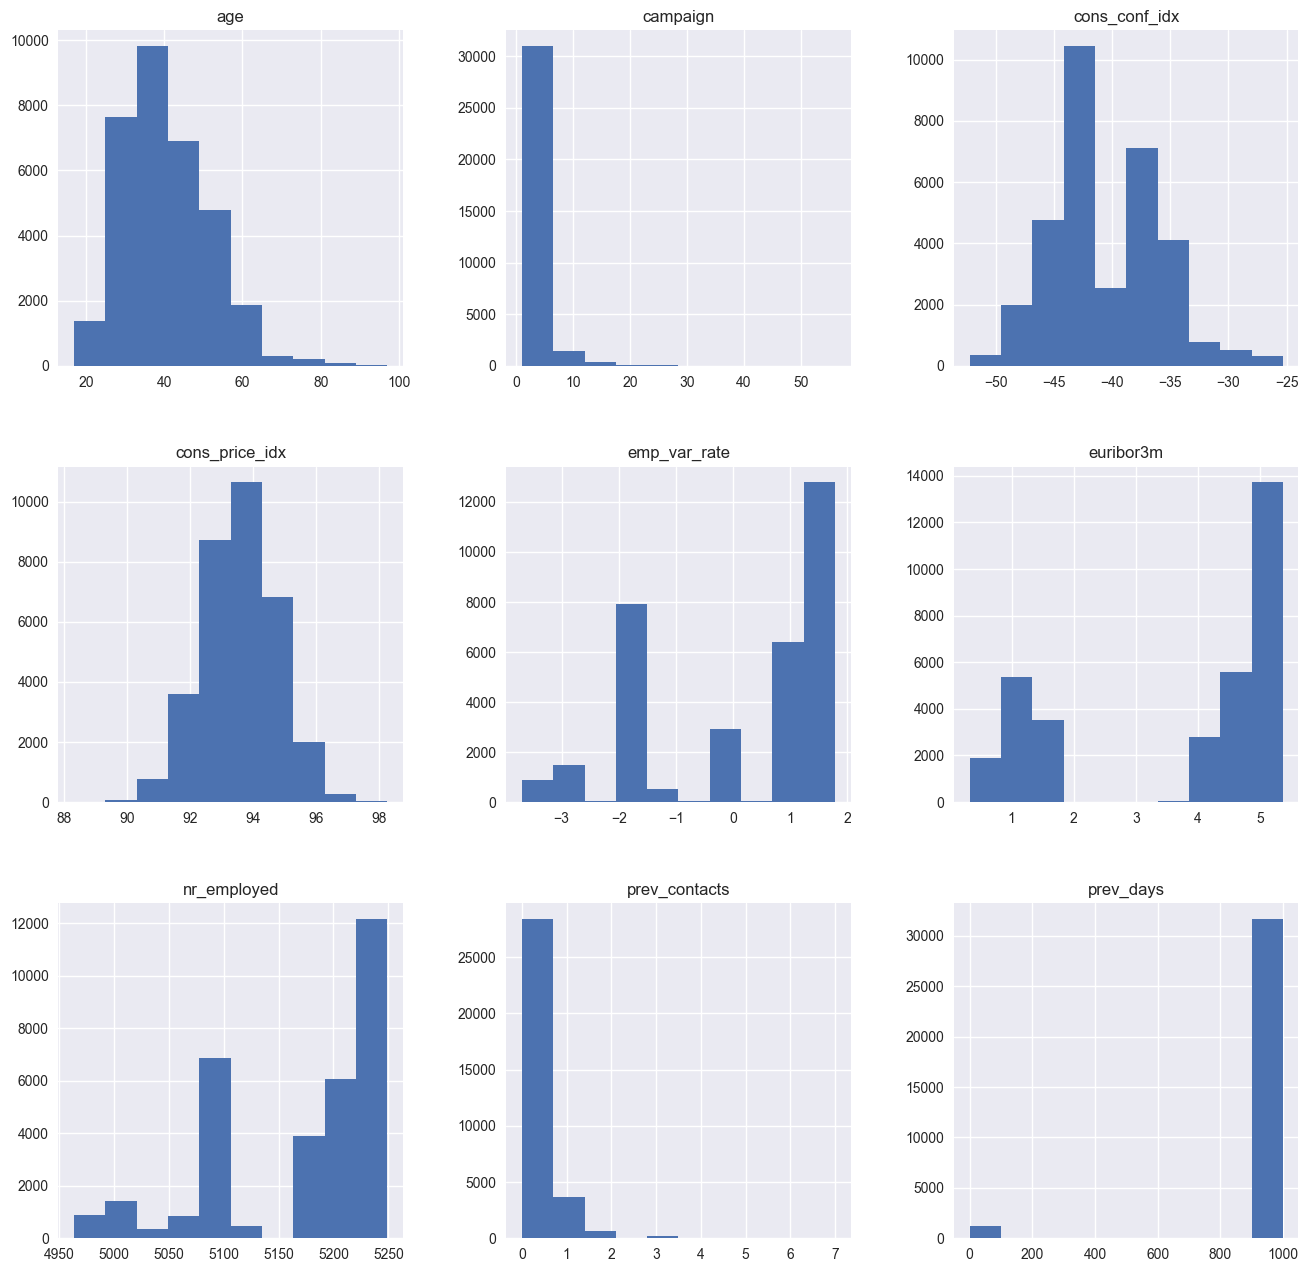

In [9]:
_ = data_df.hist(column=continuous_vars, figsize = (16,16))

### Visualizing Distribution of Categorical Variables

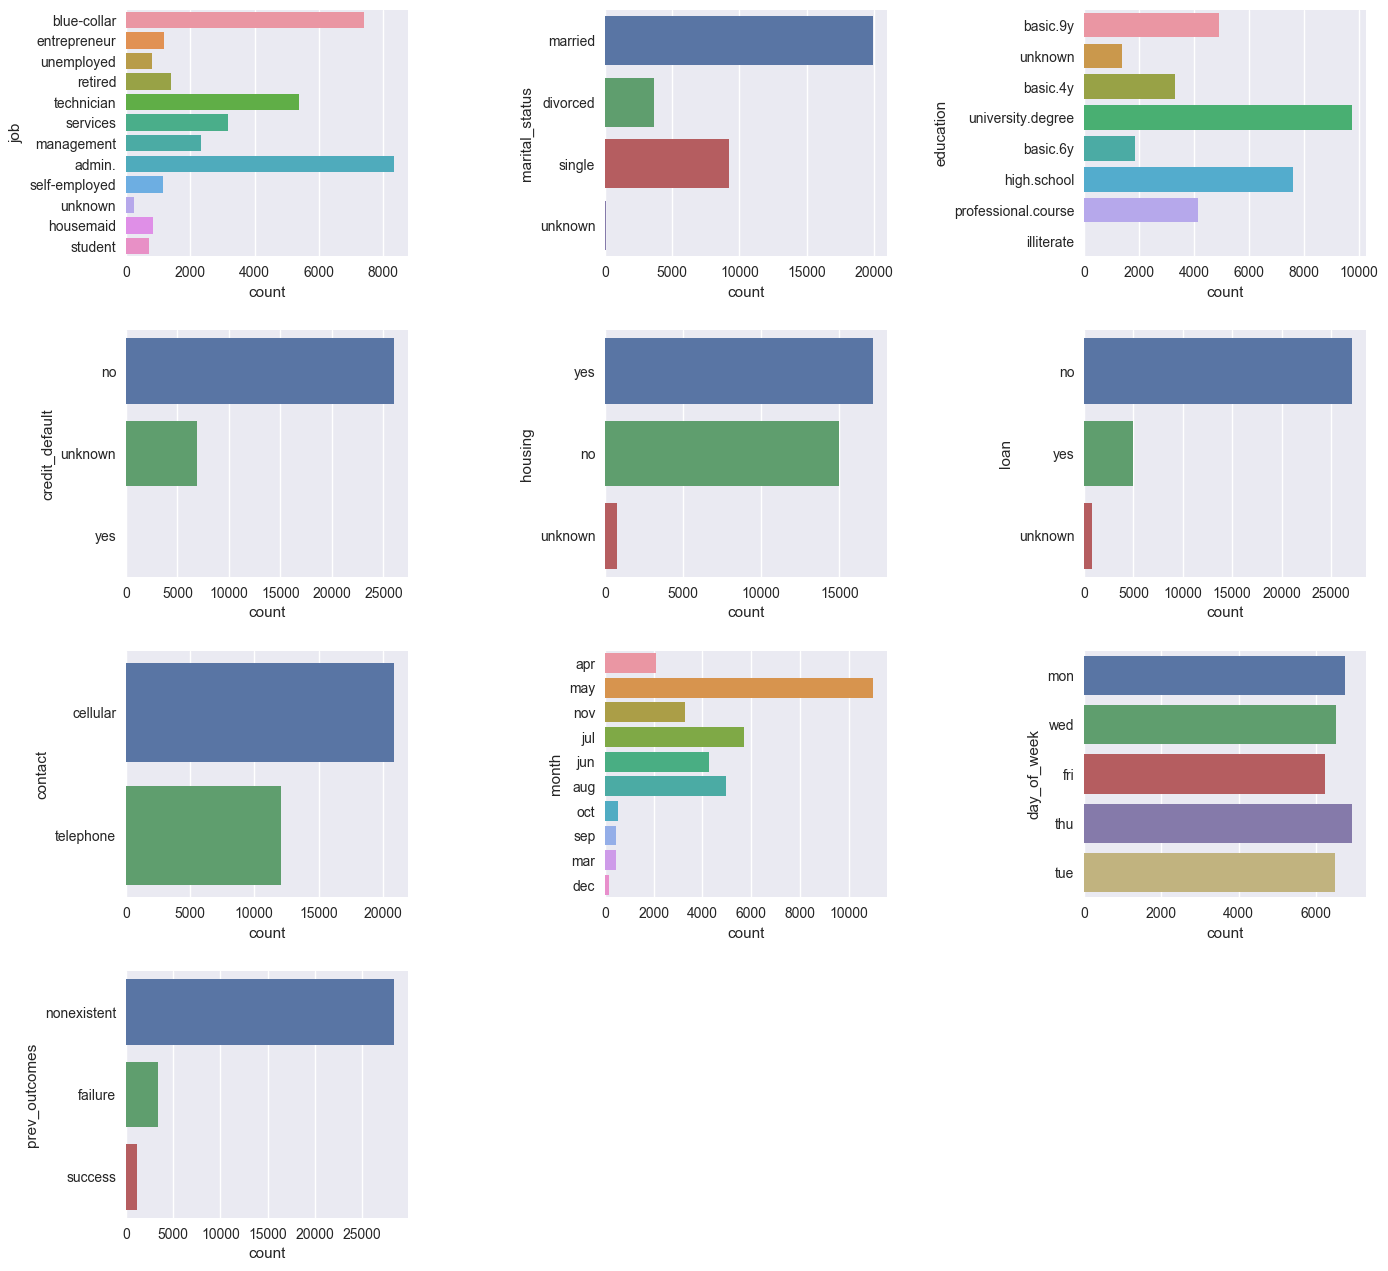

In [10]:
# Count plots of categorical variables

fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=data_df, ax=ax)

### Scatter Plot Matrix for checking Correlations (takes long to build on travis, commented)

In [11]:
#pd.tools.plotting.scatter_matrix(data_df[continuous_vars], c=subscribed, alpha=.2, figsize=(15, 15), cmap="viridis");

# Preparation

* Creating dummy variables for categorical variables
* Scaling numerical variables
* Removing variables based on variance

### Creating Dummy Variables

In [12]:
data_df.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0


In [13]:
# Creating dummy variables
data_dummies_df = pd.get_dummies(data_df, columns=categorical_vars, drop_first=True)
holdout_dummies_df = pd.get_dummies(holdout_df, columns=categorical_vars, drop_first=True)

In [14]:
#data_dummies_df.columns

In [15]:
output_df = pd.DataFrame(holdout_df["ID"])
holdout_dummies_df.drop("ID", axis=1, inplace=True)

In [16]:
#holdout_dummies_df.columns

In [17]:
holdout_dummies_df['credit_default_yes'] = 0
holdout_dummies_df = holdout_dummies_df[data_dummies_df.columns]

### Creating Submission Output

** Create the output.csv to upload on Kaggle **

In [18]:
def create_submission_output(output_df, pipe):
    output = pd.concat([output_df, pd.DataFrame(pipe.predict_proba(holdout_dummies_df)[:, 1])], axis=1)
    output.rename(columns = {0:"subscribed"}, inplace=True)
    output.set_index("ID").to_csv("output.csv")
    return output.head()

# Step2 - ModelSet1

In this step, the following steps relevant to the Machine Learning models used have been shown:

* feature engineering
* validation
* feature selection
* final model selection

### 1. Logisitc Regression CV with StandardScalar

### (a) First we build a simple logistic regression model by standardizing all the features using the Standard scaler.

** Standard Scaling just the continuous Variables **

In [19]:
categorical_dummies = pd.get_dummies(data_df[categorical_vars], drop_first=True).columns

In [20]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

select_categorical = FunctionTransformer(lambda X: X[categorical_dummies],validate = False)
select_continuous = FunctionTransformer(lambda X: X[continuous_vars],validate = False)

fu = make_union(select_categorical, make_pipeline(select_continuous, StandardScaler()))
pipe = make_pipeline(fu, LogisticRegressionCV())

print(np.mean(cross_val_score(pipe, data_dummies_df, subscribed, cv=5, scoring="roc_auc")))

0.789408598048


In [21]:
pipe.fit(data_dummies_df, subscribed)
create_submission_output(output_df, pipe)

** Standard Scaling all the features ** 

In [22]:
pipe = make_pipeline(StandardScaler(), LogisticRegressionCV())
print(np.mean(cross_val_score(pipe, data_dummies_df, subscribed, cv=5, scoring="roc_auc")))

0.791280720729


In [23]:
pipe.fit(data_dummies_df, subscribed)
create_submission_output(output_df, pipe)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

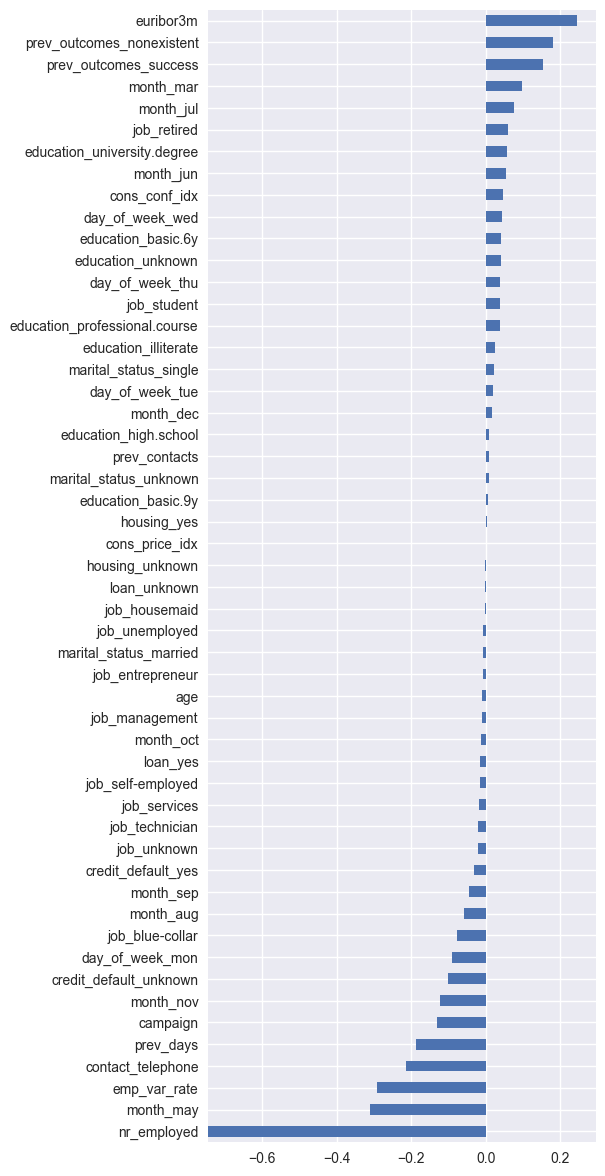

In [24]:
plt.figure(figsize=(5, 15))
coef = pd.Series(pipe.named_steps['logisticregressioncv'].coef_.ravel(), index=data_dummies_df.columns)
coef.sort_values().plot(kind="barh")

In one model we standardize only the continuous variables and leave the categorical variables as it is. 
In another model we standardize all the variables (including categorical variables). The model gives a better cross-val score in the second case. We get an average cross-val score of 78.9%, so we use StandardScaler in all the later models to Scale all the features in the pipeline.

Also, looking at the weights assigned to the features, we observe that around 50% of the variables are those with significant weights and therefore we set a feature selection threshold as 50% for a few models later.

### (b) Logistic Regression with Kernel

#### Next we use kernelized logistic regression to make our prediction. Again we use standard scaler before fitting our model.

In [25]:
approx = Nystroem(gamma=1./data_dummies_df.shape[1], n_components=300)

pipe = make_pipeline(StandardScaler(), approx, LogisticRegressionCV())

print(np.mean(cross_val_score(pipe, data_dummies_df, subscribed, cv=5, scoring="roc_auc")))

In [26]:
pipe.fit(data_dummies_df, subscribed)
create_submission_output(output_df, pipe)

Logistic Regression using Kernel Approximation did not result in an improvement as compared to LogisticRegressionCV with using a Standard Scaler.

### (c) Logistic Regression with Feature Selection

* We now perform feature selection using f_classif before fitting a Logistic model on the data.
* Feature engineering is performed by adding interaction features to our feature set. 
* Top 50 percentile of features are selected using f_classif.

In [28]:
pipe = make_pipeline(StandardScaler(), SelectPercentile(score_func=f_classif, percentile=50), 
                     PolynomialFeatures(interaction_only=True), 
                     VarianceThreshold(),
                     LogisticRegressionCV())
print(np.mean(cross_val_score(pipe, data_dummies_df, subscribed, cv=5, scoring="roc_auc")))

In [29]:
pipe.fit(data_dummies_df, subscribed)
create_submission_output(output_df, pipe)

In [30]:
roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])

We used SelectPercentile with various values in GridSearch, but as the percentage increases, the value increased which shows that even if the logistic weights are lower for a few features, they are still important for classification.

### (d) SelectFromModel : Lasso with Logistic Regression

* We wanted to perform feature selection using SelectModel, where we use LassoCV.
* Threshold was set as the median, by observing the important features using Logistic Regression from part a)

In [31]:
select_lassocv = SelectFromModel(LassoCV(), threshold="median")
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, LogisticRegressionCV())
print(np.mean(cross_val_score(pipe_lassocv, data_dummies_df, subscribed, cv=10, scoring="roc_auc")))

In [32]:
pipe_lassocv.fit(data_dummies_df, subscribed)
create_submission_output(output_df, pipe_lassocv)

Using SelectfromModel with Lasso, we get comparable CV scores as compared to Logistic Regression with StandardScaler, so we wanted to explore a lot of other parameters using GridSearch.

### (e) Logistic Regression Parameter Tuning

* Now we try to tune our hyper-parameters to obtain best hyper-parameters. 
* Since LogisticRegressionCV already tunes 'C' for logistic regression, we tune **max_features and polynomial degree**.

In [33]:
pipe = make_pipeline(SelectPercentile(score_func=f_classif, percentile=50), 
                     PolynomialFeatures(interaction_only=True), 
                     VarianceThreshold(),
                     LogisticRegressionCV())
param_grid = {'selectpercentile__percentile': [50], 
              'polynomialfeatures__degree': [2]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")

In [34]:
grid.fit(data_dummies_df, subscribed)

In [35]:
grid.best_score_

In [36]:
grid.best_params_

In [37]:
create_submission_output(output_df, grid)

We obtain a best cross-val roc_auc **score of 78.89%** after parameter tuning with features selected using f_classif.

** Observations: **

For the logistic regression, using the LogisticRegressionCV with just standard scaling works best and its CV score is comparable to the score obtained by doing feature selection using LassoCV. Therefore, we just use the LogisticRegressionCV for our ensemble methods later.

### 2. MLP Classifier

We try another linear classifier, multi-layered perceptron. 

Takes long time to build on travis, commented

In [38]:
mlp_pipe =  make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = 5))
param_grid = {'mlpclassifier__hidden_layer_sizes': [5, 10, 50, 100, 200]}
param_grid = {} # to optimize code running on travis, the best value is selected by doing the runs
grid = GridSearchCV(mlp_pipe, param_grid, cv=5, scoring="roc_auc")

In [39]:
grid.fit(data_dummies_df, subscribed)

In [40]:
grid.best_score_

In [41]:
grid.best_params_

In [42]:
create_submission_output(output_df, grid)

** Observations: **

We tried using the MLPClassifier, but it did not perform that well as compared to LogisticRegressionCV from ModelSet1.

### 3. LinearSVC Classifier with Calibration

#### We use a calibrated Linear SVM classifier.

In [43]:
scaled_svc = make_pipeline(StandardScaler(), LinearSVC())
clf = CalibratedClassifierCV(scaled_svc) 

print(np.mean(cross_val_score(clf, data_dummies_df, subscribed, cv=5, scoring="roc_auc")))

In [44]:
clf.fit(data_dummies_df, subscribed)
create_submission_output(output_df, clf)

** Observations: **

For the LinearSVC classifiers, as they do not return a predict_proba, we need to use a CalibrationClassifier to get the predict probability values.

For the LinearSVC also, we do not beat the CV validation scores in ModelSet1 using LogisticRegression Models.

---

# Step3 - ModelSet2

In this step, the following steps relevant to the Machine Learning models used have been shown:

* feature engineering
* validation
* feature selection
* final model selection

### 1. Decision Tree Classifier

In [45]:
pipe = make_pipeline(DecisionTreeClassifier(max_depth = 6))
#param_grid = {'decisiontreeclassifier__max_depth':range(1, 7)}
param_grid = {}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=StratifiedShuffleSplit(100))
grid.fit(data_dummies_df, subscribed)

In [46]:
grid.best_score_, grid.best_params_

Observations:
    
Using the Decision Trees Classifier, we tried all the parameter values for GridSearch, but it wasn't resulting in comparable CV scores to LogisticRegression, so we moved to better models, i.e., RandomForest and GradientBoosting.

### 2. Random Forest Classifier

We tune our random forest classifier by varying the following hyper-parameters:
* N-estimators
* Max Depth
* Max Features
* Criterion

** Tuning Level 1 **

In [47]:
rf = RandomForestClassifier(warm_start=True)
params = {'randomforestclassifier__n_estimators' : range(10,100,10), 
          'randomforestclassifier__max_depth' : range(3,15,2)}
pipe = make_pipeline(rf)
grid = GridSearchCV(pipe, param_grid = params, scoring='roc_auc', n_jobs=-1,iid=False, cv=5)
grid.fit(data_dummies_df, subscribed)
print(grid.best_score_)

** Tuning Level 2 **

In [48]:
rf = RandomForestClassifier(warm_start=True, n_estimators=80, max_depth=9)
params = {'randomforestclassifier__max_features' : range(7, 53, 9),
          'randomforestclassifier__criterion' : ['gini', 'entropy']}
pipe = make_pipeline(rf)
grid = GridSearchCV(pipe,param_grid = params, scoring='roc_auc', n_jobs=-1, iid=False, cv=5)
grid.fit(data_dummies_df, subscribed)
print(grid.best_score_)

** Final Model based on learned Tuned Parameters **

In [49]:
rf = RandomForestClassifier(warm_start=True, n_estimators=80,
                            max_depth=9,
                            max_features = 16, 
                            criterion = 'entropy')
params = {}
pipe = make_pipeline(rf)
grid = GridSearchCV(pipe, param_grid = params, scoring='roc_auc', n_jobs=-1,iid=False, cv=5)
grid.fit(data_dummies_df, subscribed)
print(grid.best_score_)

0.798401803402


** Observations: **

All the parameters were tuned for the Random Forest, but here we are showing just two levels of parameter tuning for brevity. 

Finally we obtain a best **cross-val score of 79.79%**. As this cross val scores are better than what we obtain for ModelSet1, the Random Forests are good candidates for creating ensembles later.

### 3. Gradient Boosting Classifier 

We tune our gradient boosting classifier by varying the following variables:
* N-estimators
* learning rate
* max depth

We obtain N-estimators = 80, learning_rate = 0.1, min_samples_split = 1000 and Max_depth = 5

In [50]:
param_test = {}
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=80, 
                                                 random_state=10, min_samples_split = 1000))
grid = GridSearchCV(pipe, param_grid = param_test, scoring='roc_auc', n_jobs=-1, iid=True, cv=5)
grid.fit(data_dummies_df, subscribed)

In [51]:
if grid.best_score_ > 0.79:
    assert True

** Observations: **
    
All the parameters were tuned for the Gradient Boosting Classifier, but as it takes a lot of time to tune the Gradient Boosting Model, we are just showing results for the best tuned model here.

Finally we obtain a best **cross-val score of 79.6%**. As this cross val scores are better than what we obtain for ModelSet1, the Gradient Boosting Methods are good candidates for creating ensembles later.

### 4. Xgboost

We also used XG boost classifier. Since we cannot pip-install XGboost, we fail to run it on Travis therefore we comment our code on XGboost. We have uploaded our output on the kaggle competition.

In [52]:
n_estimators = [50]
max_depth = [5]
learning_rate = [0.1]
subsample = [1.0]
colsample_bytree = [0.7]
colsample_bylevel = [0.6]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
param_grid = dict(xgbclassifier__n_estimators=n_estimators, 
                  xgbclassifier__max_depth=max_depth, 
                  xgbclassifier__learning_rate=learning_rate, 
                  xgbclassifier__subsample=subsample, 
                  xgbclassifier__colsample_bytree=colsample_bytree, 
                  xgbclassifier__colsample_bylevel=colsample_bylevel,
                  xgbclassifier__gamma=gamma
                 )
#kfold = StratifiedKFold(n_splits=5, shuffle=True) 
pipe = make_pipeline(StandardScaler(), XGBClassifier())
grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", n_jobs=-1, cv=10)
grid.fit(data_dummies_df, subscribed)

In [53]:
grid.best_params_

In [54]:
grid.best_score_

** Observations: **

All the parameters were tuned for the XGBoost Classifier. The good aspect of using XGBoost is that it is way faster to train as compared to Gradient Boosting, and with regularization helps in learning a better model.

Finally we obtain a best **cross-val score of 79.8%**. As this cross val scores are better than what we obtain for ModelSet1, the XGBoost Methods are good candidates for creating ensembles later.

# Step4 - Ensemble Methods

The aim here was to try poor man's stacking and other ensemble techniques as well.

### 1. Simple Ensemble: Voting Classifier, Poor-man's Stacking
* Logistic Regression CV
* Random Forest with best hyper-parameters, N-estimator = 80, max_depth = 9, max features = 16, criterion = entropy
* Gradient Boosting Classifier with best hyper-parameters, N-estimators = 200, max_depth = 5, min_samples_split = 1000

In [55]:
clf1 = make_pipeline(StandardScaler(),LogisticRegressionCV(random_state=10))
clf2 = RandomForestClassifier(warm_start=True,n_estimators=80,max_depth=9,max_features = 16, criterion = 'entropy', random_state=10)
clf3 = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, n_estimators=200, random_state=10,min_samples_split = 1000)

voting = VotingClassifier([('logreg', clf1),('RandomForest', clf2),('GradientBoost',clf3)], voting='soft')
                     
print(np.mean(cross_val_score(voting, data_dummies_df, subscribed,scoring = 'roc_auc', cv=5)))

In [56]:
## using only voting.fit is POOR MANS STACKING AND USING CROSS_VAL_PREDICT IS ACTUAL STACKING

voting.fit(data_dummies_df,subscribed)
create_submission_output(output_df, voting)

** After Voting Classifier, we used Stacking on the output probability from the Voting Classifier and build a LogisticRegression model on those probabilities to obtain the final probability **

In [57]:
from sklearn.preprocessing import FunctionTransformer

reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1, 6)[:, 1::2], validate=False)
stacking = make_pipeline(voting, reshaper,
                         LogisticRegressionCV())
print(np.mean(cross_val_score(stacking,data_dummies_df, subscribed, scoring = 'roc_auc',cv=5)))

In [58]:
stacking.fit(data_df_dummies, subscribed)
create_submission_output(output_df, stacking)

** The second stage stacking was also tried using the RandomForestClassifier, GradientBoosting and LinearRegression classifiers, but as it takes a lot of time to build, we have shown results for LogisticRegression here. ** Also, it did not help in any accuracy changes.

** Observations: **

We are able to achieve the best CV outputs using a Voting Classifier with all the best tuned models from ModelSet1 and ModelSet2.

### 2. Weighted Ensemble:

* We use a weighted ensemble model by giving more weightage to the Random Forest Classifier followed by the Gradient Boosting Classifier and Logistic Regression classifier.

In [59]:
clf1 = make_pipeline(StandardScaler(),LogisticRegressionCV(random_state=10))
clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(warm_start=True,n_estimators=80, max_depth=9, max_features = 16, criterion = 'entropy', random_state=10))
clf3 = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=0.1,max_depth=5, n_estimators=80, random_state=10, min_samples_split = 1000))

voting = VotingClassifier([('logreg', clf1), ('RandomForest', clf2), ('GradientBoost',clf3)],weights = [2, 5, 3], voting='soft')
                     
output = np.mean(cross_val_score(voting, data_dummies_df, subscribed, scoring = 'roc_auc', cv=5))
print(output)

0.798568652313


In [60]:
voting.fit(data_dummies_df,subscribed)
create_submission_output(output_df, voting)

** Observations: **

We are able to achieve the best CV outputs using a Voting Classifier with all the best tuned models from ModelSet1 and ModelSet2. It performed well when we were able to provide weights to separate classifiers for their outputs.

### 3. Ensemble with XGboost

In [61]:
clf1 = make_pipeline(StandardScaler(), XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, 
                                                     colsample_bylevel=0.6, colsample_bytree=0.7, gamma = 1.11))
clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(warm_start=True,n_estimators=80,max_depth=9,max_features = 16, criterion = 'entropy'))
clf3 = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=0.1,max_depth=5, n_estimators=200, random_state=10,min_samples_split = 1000))

voting = VotingClassifier([('xgb', clf1), ('RandomForest', clf2), ('GradientBoost',clf3)], voting='soft', weights = [1.5, 4, 3])
                     
print(np.mean(cross_val_score(voting,data_dummies_df,subscribed,scoring = 'roc_auc',cv=10)))

In [62]:
voting.fit(data_dummies_df,subscribed)
create_submission_output(output_df, voting)

**Observation:**

The cross val roc_auc score does not show any improvement by replacing the Logistic Classifier with XGboost. Although we get a similar roc_auc score of close to 0.786.

### 4. Ensemble with XGBoost, inspired by Owen Zhang

In [63]:
clf1 = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.7, colsample_bylevel=0.6, gamma = 1.11, seed=0)
clf2 = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.7, colsample_bylevel=0.6, gamma = 1.11, seed=1)
clf3 = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.7, colsample_bylevel=0.6, gamma = 1.11, seed=2)

voting = VotingClassifier([('xgb1', clf1),('xgb2', clf2),('xgb3',clf3)], voting='soft')

print(np.mean(cross_val_score(voting, data_dummies_df, subscribed, scoring = 'roc_auc', cv=5)))

In [64]:
voting.fit(data_dummies_df,subscribed)
create_submission_output(output_df, voting)

**Observation**

We tried an ensemble of 3 XGboost classifiers with different random states. This was inspired by Owen Zhang technique of acing the kaggle leader-board. We were not able to observe any significant improvement in cross val score over our simple voting classifier.

# Step 5 : Resampling

** In this section we tried Resampling with the best parameters learnt for LogisticRegression and RandomForestClassifier, as they run faster **

### 1. Undersampling with Logistic Regression : RandomUnderSampler

In [65]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [66]:
undersample_pipe.fit(data_dummies_df,subscribed)
create_submission_output(output_df, undersample_pipe)

### 2. Oversampling with Logistic Regression : RandomOverSampler

In [67]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegressionCV())
scores = cross_val_score(oversample_pipe, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [68]:
oversample_pipe.fit(data_dummies_df,subscribed)
create_submission_output(output_df, oversample_pipe)

**Observations:**

Undersampling and Oversampling give similar roc_auc scores close to 0.787 using Logistic Regression classifier

### 3. Undersampling with Random Forest Classifier : RandomUnderSampler

In [69]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), 
                                        RandomForestClassifier(warm_start=True,
                                                               n_estimators=80,
                                                               max_depth=9,
                                                               max_features = 16, 
                                                               criterion = 'entropy'))
scores = cross_val_score(undersample_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [70]:
undersample_pipe_rf.fit(data_dummies_df, subscribed)
create_submission_output(output_df, undersample_pipe_rf)

### 4. Oversampling with Random Forest Classifier : RandomOverSampler

In [71]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(warm_start=True,
                                                                                   n_estimators=80,
                                                                                   max_depth=9,
                                                                                   max_features = 16, 
                                                                                   criterion = 'entropy'))
scores = cross_val_score(oversample_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [72]:
oversample_pipe_rf.fit(data_dummies_df, subscribed)
create_submission_output(output_df,oversample_pipe_rf)

Random Over Sampler with our tuned Random Forest Classifier gives a mean roc_auc score of **0.797**. Again we do not observe any significant improvement by resampling the data.

### 5. Balancing Class Weights for Logistic Regression

In [73]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'),
                         data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(scores.mean())

### 6. Balancing Class Weights for Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=80,
                                                max_depth=9,
                                                max_features = 16, 
                                                criterion = 'entropy',
                                                class_weight='balanced'),
                         data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

## Resampled Ensembles

### 1. Trees: RF

In this model we create multiple undersampled random-forests classifiers with different random state for undersampling. Finally we build a voting classifier for all these rf classifiers.

In [75]:
def make_resample_tree(random_state=0):
    rf = RandomForestClassifier(warm_start=True,
                                n_estimators=80,
                                max_depth=9,
                                max_features = 16, 
                                criterion = 'entropy')
    tree = make_imb_pipeline(RandomUnderSampler(random_state=random_state, replacement=True),
                             rf)
    return "tree_i".format(random_state), tree
classifiers = [make_resample_tree(i) for i in range(100)]
resampled_rf = VotingClassifier(classifiers, voting='soft')

In [76]:
scores = cross_val_score(resampled_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

### 2. Ensembles using RandomUnderSampling

In [77]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

** For RandomForestClassifier ** (takes long time to run, so commented for travis)

In [78]:
rf = RandomForestClassifier(warm_start=True,
                            n_estimators=80,
                            max_depth=9,
                            max_features = 16, 
                            criterion = 'entropy')

resampled_tree_test = make_resampled_ensemble(rf)

scores = cross_val_score(resampled_tree_test, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

** For LogisticRegression ** (takes long time to run, so commented for travis)

In [79]:
resampled_lr = make_resampled_ensemble(LogisticRegressionCV())

scores = cross_val_score(resampled_lr, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

## Undersampling using Edited Nearest Neigbors (takes long time to run, so commented for travis)

In [80]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegressionCV())
scores = cross_val_score(enn_pipe, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [81]:
rf = RandomForestClassifier(warm_start=True,
                            n_estimators=80,
                            max_depth=9,
                            max_features = 16, 
                            criterion = 'entropy')

enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                                rf)
scores = cross_val_score(enn_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

Undersampling using both EditedNearestNeighbours and CondensedNearestNeighbours were tried in conjunction with both LogisticRegression and RandomForestClassifier. CondensedNearestNeigbours takes a long time to run and does not help in improving the CV score much, so not used and shown here.

## Resampling using SMOTE

In [82]:
from imblearn.over_sampling import SMOTE

** LogisticRegression**

In [83]:
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegressionCV())
scores = cross_val_score(smote_pipe, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

** RandomForestClassifier ** 

In [84]:
rf = RandomForestClassifier(warm_start=True,n_estimators=80,max_depth=9,max_features = 16, criterion = 'entropy')
smote_pipe_rf = make_imb_pipeline(SMOTE(), rf)
scores = cross_val_score(smote_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [85]:
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, scoring="roc_auc")
search.fit(data_dummies_df, subscribed)

In [86]:
search.best_params_

** From best\_params\_, we obtain the best value for k_neighbours as 7, which are used later**

** SMOTEENN and SMOTETOMEK tried, but code commented due to travis **

In [87]:
rf = RandomForestClassifier(warm_start=True,n_estimators=80,max_depth=9,max_features = 16, criterion = 'entropy')
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=7), rf)
scores = cross_val_score(smote_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [88]:
from imblearn.combine import SMOTEENN, SMOTETomek
rf = RandomForestClassifier(warm_start=True,n_estimators=80,max_depth=9,max_features = 16, criterion = 'entropy')
smoteenn_pipe_rf = make_imb_pipeline(SMOTEENN(smote=SMOTE(k_neighbors=7)), rf)
scores = cross_val_score(smoteenn_pipe_rf, data_dummies_df, subscribed, cv=10, scoring='roc_auc')
print(np.mean(scores))

#### The Under and Over Sampling techniques are applied in conjunction with Random Forest Classifier (Best Tree Classifier) 

** The resampling techniques get us CV values near 0.791-0.794, but still are not able to perform as well as Voting Classifiers or classifiers built in ModelSet1 and ModelSet2. The main reason for this can be the skewness of classes and the chosen undersample not being a good representative of all the variation that exists in that class, whereas for the other class, it always has all the variation captured. Similar observations can be made for the Oversampling case.**

** We are using the weighted ensemble method for final results, whose CV value is stored in output :: **

In [89]:
if output > 0.798:
    #print(True)
    assert True

---